In [1]:
# Add path
import os
import sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

In [2]:
# Reload modules
from importlib import reload
import util
import model
import value_decoder
import decoder
import encoder
reload(util)
reload(model)
reload(value_decoder)
reload(decoder)
reload(encoder)
from value_decoder import ValueDecoder
from decoder import Decoder
from encoder import Encoder

In [9]:
from copy import deepcopy
import torch
import numpy as np
import sympy as sp
from util import prods_to_eq, logits_to_prefix, logits_to_prods
from config_util import dict_to_config, load_config
from data_util import data2input, load_dataset, calc_priors_and_means, create_dataloader
from debug_util import plot_onehot
import wandb
from model import GrammarVAE
import yaml
from matplotlib import pyplot as plt
torch.manual_seed(41)

# Load dataset
datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
syntax, consts, val_x, val, syntax_cats = load_dataset(datapath=datapath, name='dataset_240822_1')
data_syntax = np.concatenate([syntax, consts[:, :, np.newaxis]], axis=-1)
value_transform = lambda x: torch.arcsinh(x)*0.1
val_transformed = value_transform(torch.tensor(val)).detach().numpy()

# Load model
run = 'tlqyg40u'
wandb_cache_path = f'/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/wandb_cache'
with wandb.restore('model.pth', run_path=f"luis-carretero-eth-zurich/similar-expressions-01/runs/{run}", root=wandb_cache_path, replace=True) as io:
    name = io.name
checkpoint = torch.load(name)

# Read the model parameters from the WandB config.yaml file
with wandb.restore('config.yaml', run_path=f"luis-carretero-eth-zurich/similar-expressions-01/runs/{run}", root=wandb_cache_path, replace=True) as config_file:
    config = yaml.safe_load(config_file)
    cfg = {k: v['value'] for k, v in list(config.items()) if k not in ['wandb_version', '_wandb']}
    cfg = dict_to_config(cfg)

vae_model = GrammarVAE(cfg)
vae_model.load_state_dict(checkpoint['model_state_dict'])

Using updated value decoder 2.0!


<All keys matched successfully>

### Examine std of encoder

In [10]:
datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
train_loader, test_loader, hashes = create_dataloader(datapath, 'dataset_240817_2', cfg, value_transform=lambda x: torch.arcsinh(x)*0.1)
assert all([config['dataset_hashes']['value'][key] == hashes[key] for key in config['dataset_hashes']['value']]), "Error: Using different dataset than used for training."

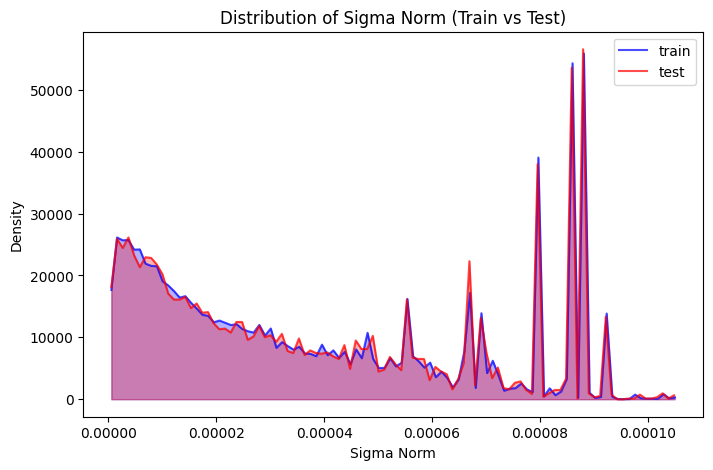

In [11]:
BATCH_SIZE = 2**15

cfg2 = deepcopy(cfg)
cfg2.training.batch_size = BATCH_SIZE
datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
train_loader, test_loader, hashes = create_dataloader(datapath, 'dataset_240817_2', cfg2, value_transform=lambda x: torch.arcsinh(x)*0.1)
assert all([config['dataset_hashes']['value'][key] == hashes[key] for key in config['dataset_hashes']['value']]), "Error: Using different dataset than used for training."


sigma_norm_train = np.empty(len(train_loader.dataset))
for i, (x, _, _, _) in enumerate(train_loader):
    # x = torch.tensor(data_syntax[:(2**15), ...].transpose(0, 2, 1))
    mu, sigma = vae_model.encoder(x)
    res = sigma.norm(dim=1).detach().numpy()
    sigma_norm_train[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = res

sigma_norm_test = np.empty(len(test_loader.dataset))
for i, (x, _, _, _) in enumerate(test_loader):
    # x = torch.tensor(data_syntax[:(2**15), ...].transpose(0, 2, 1))
    mu, sigma = vae_model.encoder(x)
    res = sigma.norm(dim=1).detach().numpy()
    sigma_norm_test[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = res

# Calculate the histogram data without plotting
train_hist, train_bins = np.histogram(sigma_norm_train, bins=100, density=True)
test_hist, test_bins = np.histogram(sigma_norm_test, bins=100, density=True)

# Calculate bin centers for plotting
train_bin_centers = (train_bins[:-1] + train_bins[1:]) / 2
test_bin_centers = (test_bins[:-1] + test_bins[1:]) / 2

# Create a plot for direct comparison
plt.figure(figsize=(8, 5))
plt.plot(train_bin_centers, train_hist, label='train', color='blue', alpha=0.7)
plt.plot(test_bin_centers, test_hist, label='test', color='red', alpha=0.7)
plt.fill_between(train_bin_centers, train_hist, alpha=0.3, color='blue')
plt.fill_between(test_bin_centers, test_hist, alpha=0.3, color='red')
plt.xlabel('Sigma Norm')
plt.ylabel('Density')
plt.title('Distribution of Sigma Norm (Train vs Test)')
plt.legend()
plt.show()

### Examine neighbourhood in latent space of training samples 

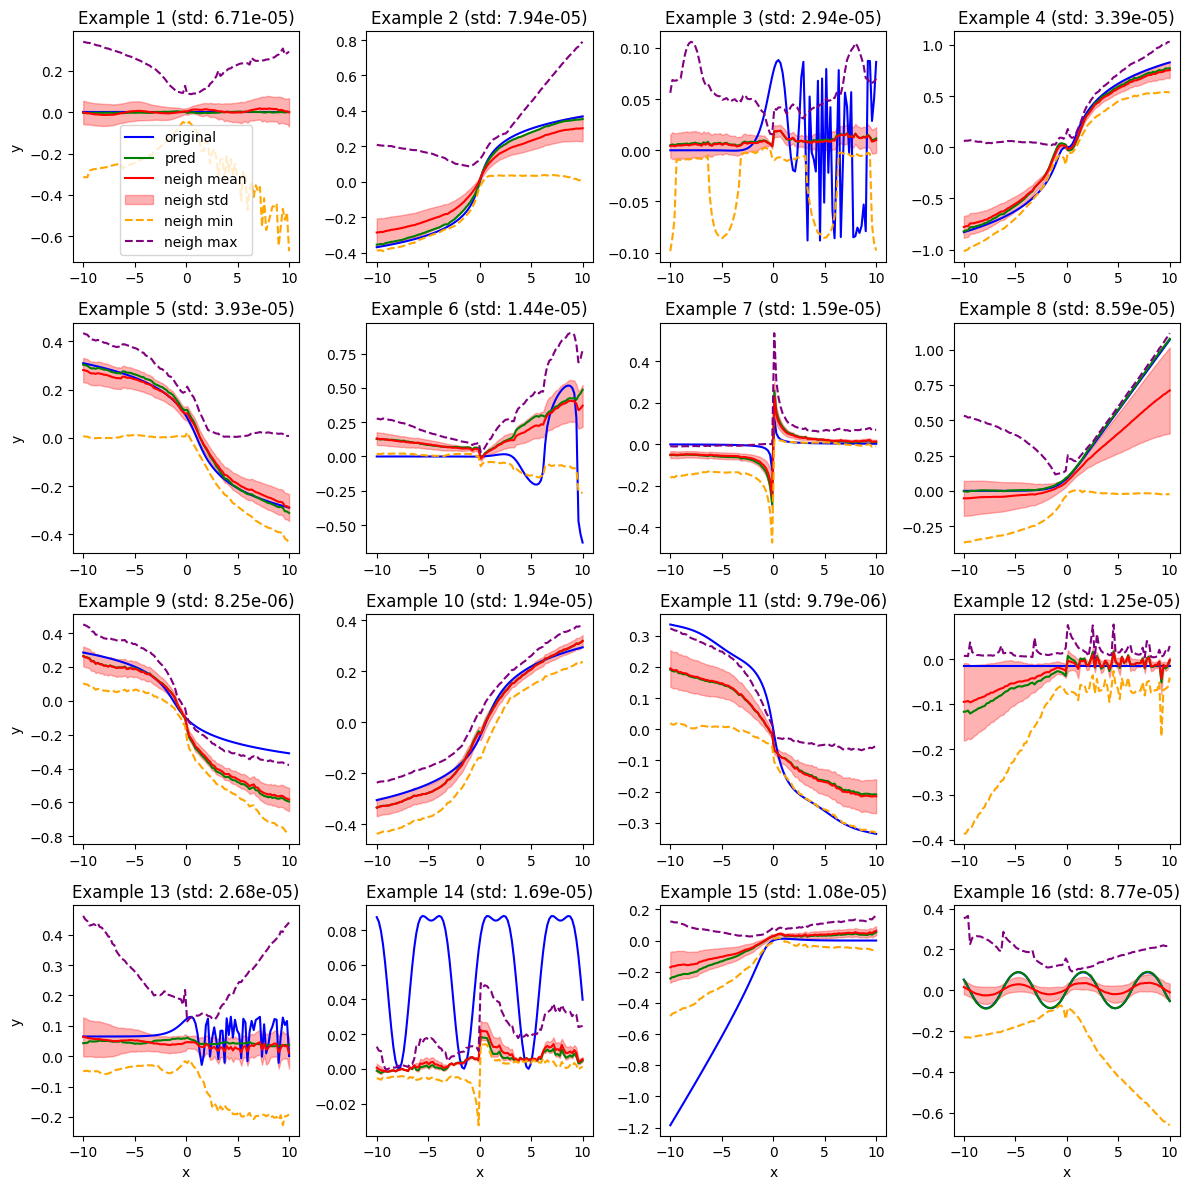

In [25]:
i = 0
N = 16
data_loader = test_loader

# Encode into latent space
x = data_loader.dataset.dataset[data_loader.dataset.indices][0][i:i+N, ...]
val_transformed = data_loader.dataset.dataset[data_loader.dataset.indices][3][i:i+N, ...]
mu, sigma = vae_model.encoder(x)
values = vae_model.value_decoder(mu)

# Sample from neighbourhood in latent space
samples = []
for _ in range(1000):  # Number of samples
    z = vae_model.sample(mu, sigma*1e2)  # Sample from neighbourhood in latent space
    values_neigh = vae_model.value_decoder(z)
    samples.append(values_neigh.squeeze().detach().numpy())
samples = np.array(samples).transpose(1, 0, 2)
mean_samples = np.mean(samples, axis=1)
std_samples = np.std(samples, axis=1)
min_samples = np.min(samples, axis=1)
max_samples = np.max(samples, axis=1)

# Plot
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()
for idx in range(N):
    ax = axes[idx]
    ax.plot(val_x.squeeze(), val_transformed[i+idx, :].squeeze(), label='original', color='blue')
    ax.plot(val_x.squeeze(), values[idx].squeeze().detach().numpy(), label='pred', color='green')
    ax.plot(val_x.squeeze(), mean_samples[idx], label='neigh mean', color='red')
    ax.fill_between(val_x.squeeze(), 
                    mean_samples[idx] - std_samples[idx], 
                    mean_samples[idx] + std_samples[idx], 
                    alpha=0.3, color='red', label='neigh std')
    ax.plot(val_x.squeeze(), min_samples[idx], label='neigh min', color='orange', linestyle='--')
    ax.plot(val_x.squeeze(), max_samples[idx], label='neigh max', color='purple', linestyle='--')
    
    if idx % 4 == 0:  # Only add y-label to the leftmost subplots
        ax.set_ylabel('y')
    if idx >= 12:  # Only add x-label to the bottom subplots
        ax.set_xlabel('x')
    ax.set_title(f'Example {idx+1} (std: {sigma[idx].norm().item():.2e})')
    
    if idx == 0:  # Only add legend to the first subplot
        ax.legend()

plt.tight_layout()
plt.show()

In [15]:
import torch.nn.functional as F

i = 2
N = 16
x = train_loader.dataset.dataset[train_loader.dataset.indices][0][i:i+N, ...]
# x = test_loader.dataset.dataset[test_loader.dataset.indices][0][i:i+N, ...]

# Encode into latent space
mu, sigma = vae_model.encoder(x)
logits = vae_model.decoder(mu, max_length=15)
values = vae_model.value_decoder(mu)

# Sample from neighbourhood in latent space
samples = []
for _ in range(1000):  # Number of samples
    z = vae_model.sample(mu, sigma*1e3)  # Sample from neighbourhood in latent space
    logits = vae_model.decoder(z, max_length=15)
    samples.append(logits.squeeze().detach().numpy())
samples = np.array(samples).transpose(1, 0, 2, 3)
syntax_samples = samples[:, :, :, :-1]
syntax_samples = F.softmax(torch.tensor(syntax_samples), dim=-1).numpy()
consts_samples = samples[:, :, :, -1]

mean_samples = np.mean(syntax_samples, axis=1)
std_samples = np.std(syntax_samples, axis=1)
min_samples = np.min(syntax_samples, axis=1)
max_samples = np.max(syntax_samples, axis=1)

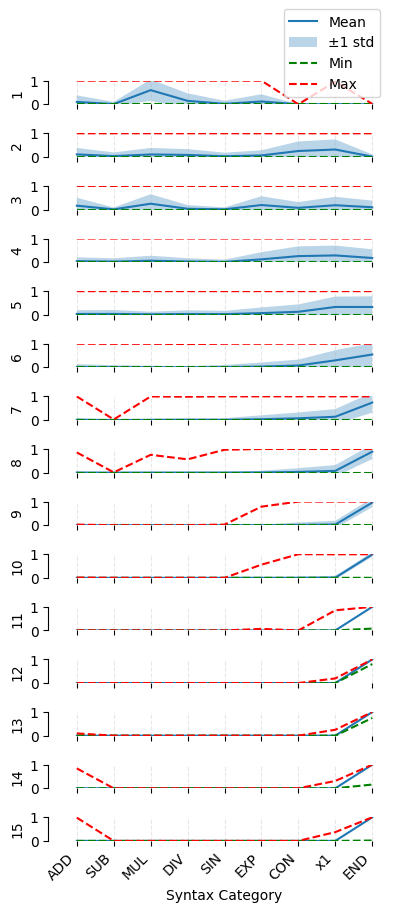

In [17]:
n = 0

fig, axes = plt.subplots(mean_samples.shape[1], 1, figsize=(4, 0.6*mean_samples.shape[1]), sharex=True)
plt.subplots_adjust(hspace=0)  # Remove vertical space between subplots
for i in range(mean_samples.shape[1]):
    axes[i].plot(mean_samples[n, i, :], label='Mean')
    axes[i].fill_between(range(mean_samples.shape[2]),
                         mean_samples[n, i, :] - std_samples[n, i, :],
                         mean_samples[n, i, :] + std_samples[n, i, :],
                         alpha=0.3, label='±1 std')
    axes[i].plot(min_samples[n, i, :], label='Min', linestyle='--', color='green')
    axes[i].plot(max_samples[n, i, :], label='Max', linestyle='--', color='red')
    axes[i].set_xticks(range(len(syntax_cats)))
    axes[i].set_xticklabels(syntax_cats, rotation=45, ha='right')
    axes[i].grid(True, axis='x', linestyle='--', alpha=0.3)
    axes[i].set_ylim(0, 1)  # Set y-limit between 0 and 1
    axes[i].set_ylabel(f'{i+1}')  # Add y-label showing timestep
    if i == mean_samples.shape[1] - 1:
        axes[i].set_xlabel('Syntax Category')
    if i == 0:
        axes[i].legend()
    axes[i].spines['top'].set_visible(False)  # Remove top border
    axes[i].spines['bottom'].set_visible(False)  # Remove bottom border
    axes[i].spines['right'].set_visible(False)  # Remove right border
    axes[i].spines['left'].set_position(('outward', 10))  # Move left spine outward

plt.tight_layout()
plt.subplots_adjust(right=0.98)  # Reduce right margin
plt.show()

In [76]:
x.squeeze(0).T.detach().numpy().shape

(15, 10)

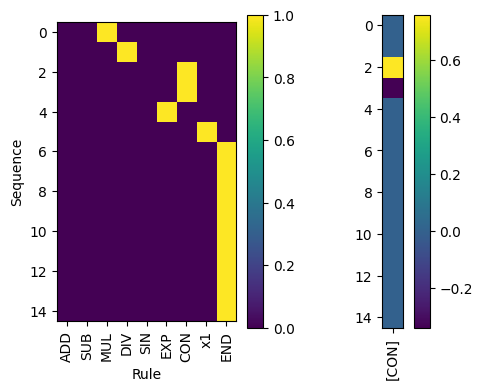

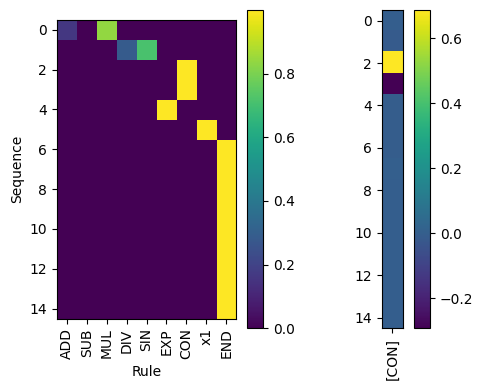

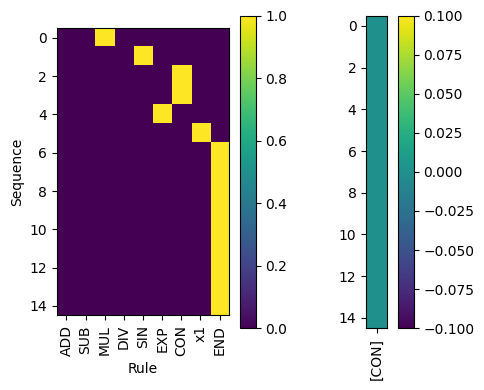

In [75]:
x = train_loader.dataset.dataset[train_loader.dataset.indices][0][0, ...].unsqueeze(0)

logits, values = vae_model(x)

plot_onehot(x.squeeze(0).T.detach().numpy(), syntax_cats, figsize=(5, 4))
plot_onehot(logits.squeeze(0).detach().numpy(), syntax_cats, apply_softmax=True, figsize=(5, 4))
# Convert logits to one-hot encoding
logits_np = logits.squeeze(0).detach().numpy()
one_hot = np.zeros_like(logits_np)
one_hot[np.arange(len(logits_np)), logits_np.argmax(axis=1)] = 1
plot_onehot(one_hot, syntax_cats, figsize=(5, 4))
